In [2]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, Galactic
import healpy as hp
import sys
sys.path.append('/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/scripts/')
import HSCMeasurementUtils
import healsparse

In [3]:
path = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_reanalysis/data_javi/lens_sample_2023_pdr1'
path_save = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/mask/'

###########################
Processing GAMA09H
###########################


Number of observed objects = 6496607
Number of stars = 1128219 (17.0%)
>> Mask type: star


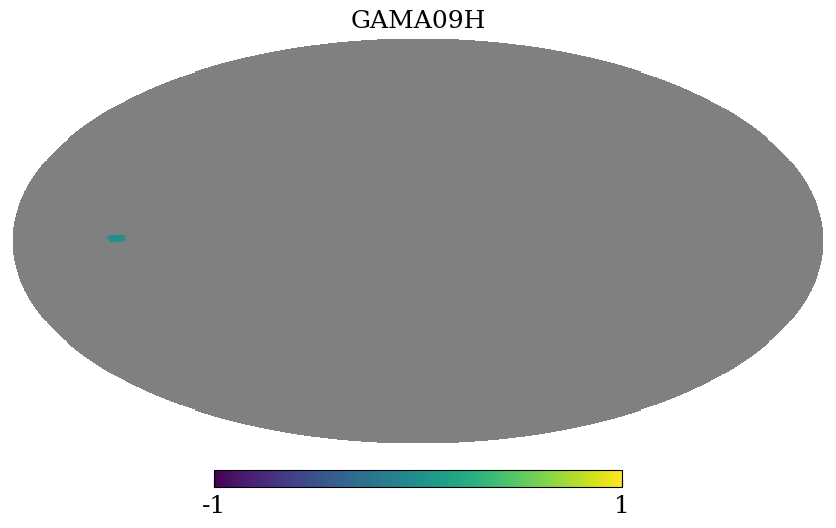

setting the output map dtype to [dtype('float64')]


>> Saving in Healpix format
>> Saving in Healsparse format


In [4]:
# Do we want to plot the field with stars and galaxies?
plot_field = True
plot_footprint = False

# Which kind of mask?
mask_type = 'galaxy' # 'galaxy' or 'star' or 'masked_fraction'
# 'galaxy' = 1 if there is a galaxy, 0 otherwise
# 'star' = 1 if there is a star, 0 otherwise
# 'masked_fraction' = 1 - 1 / number of galaxies per pixel

# Resolution of the map
nside = 4096

# HSC Fields
fname_list = ['gama09h_pdr1.fits']#, 'gama15h_pdr1.fits', 'wide12h_pdr1.fits', 'xmm_pdr1.fits', 'vvds_pdr1.fits']
label_list = ['gama09h', 'gama15h']#, 'wide12h', 'xmm', 'vvds']

for fname, label in zip(fname_list, label_list):
    print("###########################")
    print(f"Processing {label.upper()}")
    print("###########################")
    # Filename of the specific field
    fname = os.path.join(path, fname)
    # Read the data
    hdul = fits.open(fname)
    # Data is in the second extension
    data = hdul[1].data
    # Header
    header = hdul[1].header
    # Select stars 
    stars_cond = data['iclassification_extendedness'] == 0
    # Extract RA and Dec    
    ra = data['ra']
    print(f'Number of observed objects = {len(ra)}')
    dec = data['dec']
    # Keep information from stars
    ra_stars = ra[stars_cond]
    dec_stars = dec[stars_cond]
    print(f'Number of stars = {sum(stars_cond)} ({np.round(sum(stars_cond) / len(ra),2)*100}%)')
    # Create a SkyCoord object with RA and Dec
    pix_indices_stars = HSCMeasurementUtils.RaDecToIndex(ra_deg = ra_stars,
                                                        dec_deg = dec_stars,
                                                        nside = nside)
    pix_indices_galaxy = HSCMeasurementUtils.RaDecToIndex(ra_deg = ra,
                                                         dec_deg = dec,
                                                         nside = nside)
    # Reference to copy header
    fname_ref = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_gama09hcorr_nohectomap.hs'
    mask = healsparse.HealSparseMap.read(fname_ref)
    mask = np.ones(12 * nside ** 2) * hp.UNSEEN 
    # Compute the number of pixels corresponding to the resolution
    npix = 12 * nside ** 2
    if mask_type == 'galaxy':
        print('>> Mask type: galaxy')
        # Simple version
        mask[pix_indices_galaxy] = 1
    elif mask_type == 'star':
        print('>> Mask type: star')
        # Simple version
        mask[pix_indices_galaxy] = 1
        mask[pix_indices_stars] = 0
    elif mask_type == 'masked_fraction':
        print('>> Mask type: masked fraction')
        # Compute the number of galaxies per pixel
        map_galaxy = np.bincount(pix_indices_galaxy, minlength=npix)
        # Compute the inverse of the number of galaxies per pixel
        mask = 1 - 1 / map_galaxy
    # Reorder pixels to nest ordering
    mask = hp.reorder(mask, r2n=True)

    if plot_field == True:
        hp.mollview(mask, title=label.upper(), nest=True)
        plt.show()
        plt.close()
    if plot_footprint == True:
        # Plot field with stars and galaxies
        plt.plot(ra, dec, 'k.', markersize=0.01,label='Galaxies')
        plt.plot(ra_stars, dec_stars, 'r.', markersize=0.01,label='Stars')
        # Title is the label in capital letters
        plt.title(label.upper())
        plt.xlabel('R.A. [deg.]')
        plt.ylabel('Dec. [deg.]')
        plt.legend(frameon=False)
        plt.show()
        plt.close()
    # Save
    print('>> Saving in Healpix format')
    path_aux = os.path.join(path_save,mask_type)
    # Check if path_aux exists and create it if not
    if not os.path.exists(path_aux):
        os.makedirs(path_aux)
    hp.write_map(os.path.join(path_aux, f'mask_{mask_type}_nside{nside}.fits'),
                 mask,
                 nest=True,
                 overwrite=True)
    # To create a new map, the resolutions and datatype must be specified
    nside_coverage = 32
    nside_sparse = 4096
    # Initialize empty Healsparse map
    map3 = healsparse.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
    # Update values 
    map3.update_values_pix(np.arange(12*nside_sparse**2), mask, nest=True)
    # In healsparse format
    print('>> Saving in Healsparse format')
    map3.write(os.path.join(path_aux,f'mask_{mask_type}_nside{nside}_{label}.hs'), clobber=True)

In [34]:
np.any(mask == hp.UNSEEN)

False

In [33]:
12 * 4096**2

201326592

In [27]:
fname_ref = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_data/masked_fraction_nside4096_gama09hcorr_nohectomap.hs'
mask = healsparse.HealSparseMap.read(fname_ref)
# transform to healpix
mask = mask.generate_healpix_map(nside=2048)


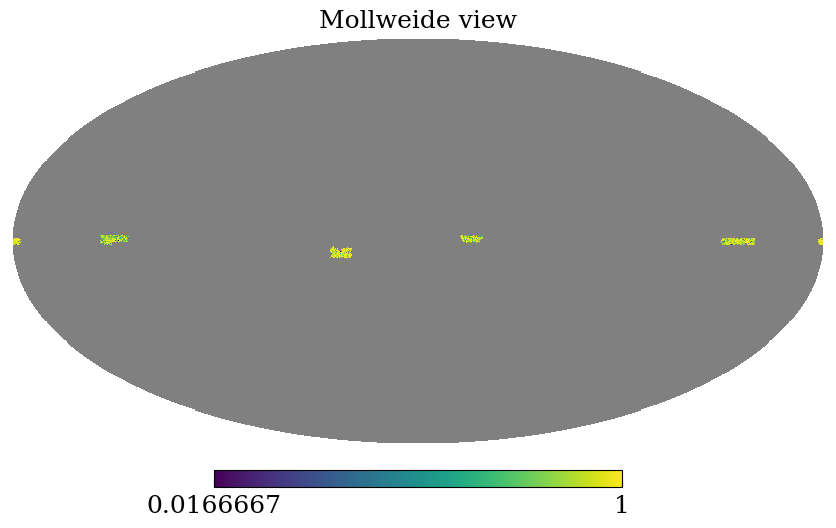

In [30]:
hp.mollview(mask, nest=True)